# WASSA2023

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dependencies

In [2]:
repo_path = "https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/"
branch = "main"

In [3]:
!pip install transformers -q
!pip install accelerate -U -q
!pip install datasets -q
!pip install torch-summary -q
# !pip install graphviz -q
# !pip install torchview -q TODO:
!pip install bertviz -q
!pip install NRCLex -q
!pip install textblob -q
!python -m textblob.download_corpora -q

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [4]:
utils_url = f"{repo_path}{branch}/utils.py"
evaluation_url = f"{repo_path}{branch}/evaluation.py"

import os
if os.path.exists("utils.py"):
  !rm "utils.py"
if os.path.exists("evaluation.py"):
  !rm "evaluation.py"

!wget {utils_url}
!wget {evaluation_url}

--2023-07-20 08:21:36--  https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40057 (39K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]  39.12K  --.-KB/s    in 0.003s  

2023-07-20 08:21:36 (11.8 MB/s) - ‘utils.py’ saved [40057/40057]

--2023-07-20 08:21:36--  https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/main/evaluation.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10675 (10K) [text/pl

In [5]:
EMO_json_path_train = f"{repo_path}{branch}/datasets/EMO23_lexicon_per_word_.json"
EMP_json_path_train = f"{repo_path}{branch}/datasets/EMP23_lexicon_per_word_.json"
EMO_json_path_test = f"{repo_path}{branch}/datasets/EMO23_lexicon_per_word_test.json"
EMP_json_path_test = f"{repo_path}{branch}/datasets/EMP23_lexicon_per_word_test.json"

!wget {EMO_json_path_train}
!wget {EMP_json_path_train}
!wget {EMO_json_path_test}
!wget {EMP_json_path_test}

--2023-07-20 08:21:36--  https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/main/datasets/EMO23_lexicon_per_word_.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14536741 (14M) [text/plain]
Saving to: ‘EMO23_lexicon_per_word_.json.1’

EMO23_lexicon_per_w 100%[===================>]  13.86M  --.-KB/s    in 0.1s    

2023-07-20 08:21:36 (94.9 MB/s) - ‘EMO23_lexicon_per_word_.json.1’ saved [14536741/14536741]

--2023-07-20 08:21:36--  https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/main/datasets/EMP23_lexicon_per_word_.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.

In [6]:
import sys
from typing import Optional, Union, Tuple
import json
import random
import string
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.utils.data import Dataset
from transformers import (
	TrainingArguments,
	Trainer,
	TrainerCallback,
	EarlyStoppingCallback,
	AutoTokenizer,
	BertModel,
	RobertaModel,
	BertForSequenceClassification,
	RobertaForSequenceClassification
	)
from transformers.modeling_outputs import SequenceClassifierOutput
from nrclex import NRCLex
import importlib
from utils import *
importlib.reload(sys.modules['utils'])

<module 'utils' from '/content/utils.py'>

In [7]:
# set CUDA if available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("======= CUDA Available =======")
else:
    device = torch.device('cpu')
    print("======= CUDA NOT Available, run on CPU =======")

======= CUDA Available =======


## Set up

In [8]:
EMOTIONS_LEX = [
    'fear',
    'anger',
    'anticipation',
    'trust',
    'surprise',
    'positive',
    'negative',
    'sadness',
    'disgust',
    'joy',
    'hope'
]

EMOTIONS_TO_PREDICT = [
    'sadness',
    'neutral',
    'fear',
    'anger',
    'surprise',
    'joy',
    'hope',
    'disgust'
]

config = {}

In [9]:
#@title Task type
TASK = "EMO" #@param ["EMO", "EMP"]
EMP_levels = "" #@param ["", "3", "5"]
include_predicted_prompt = True #@param {type:"boolean"}
prompt_inlcusion_prob_train = "0.2" #@param {type:"string"}
prompt_inlcusion_prob_train = float(prompt_inlcusion_prob_train)
prompt_inlcusion_prob_val = "0" #@param {type:"string"}
prompt_inlcusion_prob_val = float(prompt_inlcusion_prob_val)
prompt_inlcusion_prob_dev = "0" #@param {type:"string"}
prompt_inlcusion_prob_dev = float(prompt_inlcusion_prob_dev)

In [10]:
#@title Number of labels
num_labels = 7 #@param {type:"integer"}
neutral_zero = False
if TASK == "EMO":
    if num_labels==7:
        neutral_zero = True
    else:
        num_labels = 8
config['num_labels'] = num_labels

In [11]:
#@title Model Class
model_id = 'mask' #@param {type:"string"}
model_class_string = "RobertaPreTrainedModel" #@param ["BertPreTrainedModel", "RobertaPreTrainedModel"]
model_name = 'roberta-go' #@param ["bert-base", "roberta-base", "roberta-emotion", "distilroberta-emotion", "roberta-empathy", "roberta-go"]

if model_class_string == "BertPreTrainedModel":
  model_class = BertForSequenceClassification
else:
  model_class = RobertaForSequenceClassification

config['model_id'] = model_id
config['model_class_string'] = model_class_string
config['model_name'] = model_name

In [12]:
#@title Global Features
emo_count_global = False #@param {type:"boolean"}
empathy_count_global = False #@param {type:"boolean"}
distress_count_global = False #@param {type:"boolean"}
bio_global = True #@param {type:"boolean"}
gold_emotions = False #@param {type:"boolean"}
gold_empathy = False #@param {type:"boolean"}
gold_distress = False #@param {type:"boolean"}

if TASK == "EMO":
  gold_emotions = False
if TASK =="EMP":
  gold_distress = False
  gold_empathy = False

global_features_names = []
emotions_count = ['fear_count',	'anger_count','anticipation_count',	'trust_count',
                 'positive_count',	'negative_count', 'surprise_count',
                 'sadness_count',	'disgust_count',	'joy_count',	'hope_count']
bio = ['gender', 'age', 'income', 'race', 'education']
if emo_count_global:
  for emo in emotions_count: global_features_names.append(emo)
if empathy_count_global: global_features_names.append('empathy_count')
if distress_count_global: global_features_names.append('distress_count')
if bio_global:
  for b in bio: global_features_names.append(b)

if gold_empathy: global_features_names.append('empathy')
if gold_distress: global_features_names.append('distress')

config['emo_count_global'] = emo_count_global
config['empathy_count_global'] = empathy_count_global
config['distress_count_global'] = distress_count_global
config['bio_global'] = bio_global
config['gold_emotions'] = gold_emotions
config['gold_empathy'] = gold_empathy
config['gold_distress'] = gold_distress
config['global_features_names'] = global_features_names


In [13]:
#@title Local Features
emo_count_local = False #@param {type:"boolean"}
empathy_count_local = False #@param {type:"boolean"}
distress_count_local = False #@param {type:"boolean"}

local_features_names = []
num_local_features = 0
if emo_count_local:
  local_features_names.append('emotions')
  num_local_features += len(EMOTIONS_NAMES)
if empathy_count_local:
  local_features_names.append('empathy')
  num_local_features += 1
if distress_count_local:
  local_features_names.append('distress')
  num_local_features += 1

if len(local_features_names) == 0: local_features_names = None

config['emo_count_local'] = emo_count_local
config['empathy_count_local'] = empathy_count_local
config['distress_count_local'] = distress_count_local
config['local_features_names'] = local_features_names

dim_extra_features = 0
if gold_emotions:
  dim_extra_features = len(global_features_names) + 8
else:
  dim_extra_features = len(global_features_names)

In [14]:
#@title Prompt
bio_prompt = False #@param {type:"boolean"}
bio_sep = 'before SEP' #@param ["after SEP", "before SEP"]
emo_prompt = True #@param {type:"boolean"}
emo_sep = 'after SEP' #@param ["after SEP", "before SEP"]
empathy_prompt = False #@param {type:"boolean"}
emp_sep = 'after SEP' #@param ["after SEP", "before SEP"]

prompt_names_before_SEP = []
prompt_names_after_SEP = []
if bio_prompt:
    if bio_sep=='before SEP':
        prompt_names_before_SEP.append('prompt_bio')
    else:
        prompt_names_after_SEP.append('prompt_bio')
if empathy_prompt:
    if emp_sep=='before SEP':
        prompt_names_before_SEP.append('prompt_emp')
    else:
        prompt_names_after_SEP.append('prompt_emp')
if emo_prompt:
    if emo_sep=='before SEP':
        prompt_names_before_SEP.append('prompt_emo')
    else:
        prompt_names_after_SEP.append('prompt_emo')

config['bio_prompt'] = bio_prompt
config['emo_prompt'] = emo_prompt
config['empathy_prompt'] = empathy_prompt
config['prompt_names_before_SEP'] = prompt_names_before_SEP
config['prompt_names_after_SEP'] = prompt_names_after_SEP

In [15]:
#@title Last CLSs
n_last_cls = 1 #@param {type:"integer"}
mean_last_cls = False #@param {type: "boolean"}
concat_local_features = False #@param {type: "boolean"}
config['n_last_cls'] = n_last_cls
config['mean_last_cls'] = mean_last_cls
config['concat_local_features'] = concat_local_features

if concat_local_features:
  dim_extra_features += num_local_features

config['dim_extra_features'] = dim_extra_features

In [16]:
#@title Model configuration
train_batch_size = 8 #@param {type:"integer"}
val_batch_size = 8 #@param {type:"integer"}
learning_rate = 2e-5 #@param {type:"number"}
weight_decay = 0.08 #@param {type:"number"}
epochs = 30 #@param {type:"integer"}
patience = 5 #@param {type:"integer"}
dropout = 0.3 #@param {type:"number"}
weighted_loss = "None" #@param ["None", "normalized_inverse", "balanced"]

model_type ={
  'distilroberta-emotion':'j-hartmann/emotion-english-distilroberta-base',
  'roberta-emotion':'j-hartmann/emotion-english-roberta-large',
  'roberta-empathy': 'bdotloh/roberta-base-empathy',
  'bert-base': 'bert-base-cased',
  'roberta-base' : 'roberta-base',
  'roberta-go': 'SamLowe/roberta-base-go_emotions'
}

model_config = {
    'model_id': model_id,
    'tokenizer_name': model_type.get(model_name),
    'model_name': model_type.get(model_name),
    'train_batch_size': train_batch_size,
    'val_batch_size': val_batch_size,
    'learning_rate': learning_rate,
    'weight_decay': weight_decay,
    'epochs': epochs,
    'seed': 42,
    'patience': patience,
    'early_stopping_threshold': 0,
    'weighted_loss': weighted_loss,
    'dropout' : dropout
}



In [17]:
path_tosave = f"{TASK}_{model_config['model_id']}"
!mkdir $path_tosave

config.update(model_config)
write_dict_to_json(config, f"{path_tosave}/config.json")

print("\nCONFIGURATION")
for k,v in config.items():
  print(f"{k}: {v}")

mkdir: cannot create directory ‘EMO_mask’: File exists

CONFIGURATION
num_labels: 7
model_id: mask
model_class_string: RobertaPreTrainedModel
model_name: SamLowe/roberta-base-go_emotions
emo_count_global: False
empathy_count_global: False
distress_count_global: False
bio_global: True
gold_emotions: False
gold_empathy: False
gold_distress: False
global_features_names: ['gender', 'age', 'income', 'race', 'education']
emo_count_local: False
empathy_count_local: False
distress_count_local: False
local_features_names: None
bio_prompt: False
emo_prompt: True
empathy_prompt: False
prompt_names_before_SEP: []
prompt_names_after_SEP: ['prompt_emo']
n_last_cls: 1
mean_last_cls: False
concat_local_features: False
dim_extra_features: 5
tokenizer_name: SamLowe/roberta-base-go_emotions
train_batch_size: 8
val_batch_size: 8
learning_rate: 2e-05
weight_decay: 0.08
epochs: 30
seed: 42
patience: 5
early_stopping_threshold: 0
weighted_loss: None
dropout: 0.3


## Dataset

### WASSA dataset

In [18]:
class WASSADataset(Dataset):

    def __init__(
        self,
        tokenizer,
        essay,
        essay_id,
        targets,
        prompt_before_SEP=None,
        prompt_after_SEP=None,
        prompt_inlcusion_prob=0.5,
        EMP_lexicon = None,
        EMO_lexicon = None,
        global_features = None,
        local_emotions = False,
        local_empathy = False,
        local_distress = False,
        max_len=None
        ):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.essay = essay
        self.essay_id = essay_id
        self.targets = targets
        self.EMP_lexicon = EMP_lexicon
        self.EMO_lexicon = EMO_lexicon
        self.prompt_before_SEP = prompt_before_SEP
        self.prompt_after_SEP = prompt_after_SEP
        self.prompt_inlcusion_prob = prompt_inlcusion_prob
        self.global_features = global_features
        self.local_emotions = local_emotions
        self.local_empathy = local_empathy
        self.local_distress = local_distress

    def __len__(self):
        return len(self.essay)

    def __getitem__(self, index):
        essay = str(self.essay[index])
        essay_id = self.essay_id[index]
        mask = self.tokenizer.convert_ids_to_tokens(self.tokenizer.mask_token_id)
        words_to_mask = EMOTIONS_TO_PREDICT + ['low', 'high', 'medium', 'medium-low', 'medium-high']

        prompt_before_SEP = ""
        if self.prompt_before_SEP is not None:
          for p in self.prompt_before_SEP[index]:
            prompt_before_SEP += " " + str(p)

        prompt_after_SEP = ""
        random_float = random.random()
        if self.prompt_after_SEP is not None:
          for p in self.prompt_after_SEP[index]:
            prompt_after_SEP += " " + str(p)
          if random_float < self.prompt_inlcusion_prob:
            for word in words_to_mask:
              prompt_after_SEP = prompt_after_SEP.replace(word, mask)

        text = essay
        text_pair = None
        if prompt_before_SEP != "":
          text += str(prompt_before_SEP)
        if prompt_after_SEP != "":
          text_pair = str(prompt_after_SEP)

        inputs = self.tokenizer.encode_plus(
            text=essay,
            text_pair=text_pair,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
            return_token_type_ids=True
        )

        item = {
          'input_ids': inputs['input_ids'].flatten(),
          'attention_mask': inputs['attention_mask'].flatten(),
          'token_type_ids': inputs["token_type_ids"].flatten()
        }

        if self.targets is not None:
          item['labels'] = torch.FloatTensor(self.targets[index])

        if self.global_features is not None:
          item['global_features'] = self.global_features[index]

        n_local_features = 0
        features_tokens_row = []
        if self.local_emotions:
          n_local_features += len(EMOTIONS_LEX)
          for i in range(len(EMOTIONS_LEX)):
            features_tokens_row.append(0)
        if self.local_empathy:
          n_local_features += 1
          features_tokens_row.append(4)
        if self.local_distress:
          n_local_features += 1
          features_tokens_row.append(0)

        if n_local_features > 0:
          features_tokens = np.full((self.tokenizer.model_max_length, n_local_features), features_tokens_row)
        else:
          features_tokens = None

        word_count=0
        first_char=True
        last_char_is_space=False
        for char_idx, char in enumerate(essay):
          token_idx = inputs.char_to_token(char_idx)
          if token_idx is None:
            if first_char: last_char_is_space=True
            if not last_char_is_space and not first_char:
              word_count+=1
              last_char_is_space=True
            continue
          elif last_char_is_space:
            last_char_is_space=False
          first_char=False

          j = 0
          if char not in string.punctuation:
            if self.local_emotions:
              for i, emo in enumerate(EMOTIONS_LEX):
                features_tokens[token_idx][i] = self.EMO_lexicon[str(essay_id)][emo][word_count]
              j += len(EMOTIONS_LEX)

            if self.local_empathy:
              features_tokens[token_idx][j] = self.EMP_lexicon[str(essay_id)]['empathy'][word_count]
              j += 1


            if self.local_distress:
              features_tokens[token_idx][j] = self.EMP_lexicon[str(essay_id)]['distress'][word_count]

        if features_tokens is not None:
            item['local_features'] = torch.FloatTensor(features_tokens)

        return item

Read dataframes

In [19]:
TRAIN_DATA = f"{repo_path}{branch}/datasets/WASSA23_essay_level_original_internal_train_preproc.tsv"
VAL_DATA = f"{repo_path}{branch}/datasets/WASSA23_essay_level_original_internal_val_preproc.tsv"
DEV_DATA = f"{repo_path}{branch}/datasets/WASSA23_essay_level_dev_preproc.tsv"

train_df = pd.read_csv(TRAIN_DATA, sep='\t')
val_df = pd.read_csv(VAL_DATA, sep='\t')
dev_df = pd.read_csv(DEV_DATA, sep='\t')

if TASK=="EMP" and EMP_levels!="":
  train_df = add_emp_dist_levels(train_df)
  train_df = add_prompt_truth(train_df, TASK, EMP_levels)
  val_df = add_emp_dist_levels(val_df)
  val_df = add_prompt_truth(val_df, TASK, EMP_levels)
  dev_df = add_emp_dist_levels(dev_df)
  dev_df = add_prompt_truth(dev_df, TASK, EMP_levels)
if TASK=="EMO":
  train_df = add_prompt(train_df, TASK)
  val_df = add_prompt_truth(val_df, TASK)
  dev_df = add_prompt_truth(dev_df, TASK)

Encode targets

In [20]:
if TASK =="EMO":
  if neutral_zero:
    label_encoder = EmotionsLabelEncoderNeutral()
  else:
    label_encoder = EmotionsLabelEncoder()
  label_encoder.fit(train_df.emotion)
  y_train = label_encoder.encode(train_df.emotion)
  y_val = label_encoder.encode(val_df.emotion)
  y_dev = label_encoder.encode(dev_df.emotion)

if TASK == "EMP":
  y_train = np.array(train_df[['empathy', 'distress']])
  y_val = np.array(val_df[['empathy', 'distress']])
  y_dev = np.array(dev_df[['empathy', 'distress']])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['neutral'] will be ignored
  warnings.warn(


Extra global features

In [21]:
global_features_train = None
global_features_val = None
global_features_dev = None

if len(config.get('global_features_names')) > 0:
  scaler = StandardScaler()
  scaler.fit(np.array(train_df[config.get('global_features_names')]))

  def standard_scalar_features(features):
    return scaler.transform(features)


  global_features_train =  standard_scalar_features(np.array(train_df[config.get('global_features_names')]))
  global_features_val =  standard_scalar_features(np.array(val_df[config.get('global_features_names')]))
  global_features_dev =  standard_scalar_features(np.array(dev_df[config.get('global_features_names')]))

  if TASK == "EMP" and config.get('gold_emotions'):
    label_encoder = EmotionsLabelEncoder()
    label_encoder.fit(train_df.emotion)
    gold_emotions_train = label_encoder.encode(train_df.emotion)
    gold_emotions_val = label_encoder.encode(val_df.emotion)
    gold_emotions_dev = label_encoder.encode(dev_df.emotion)
    global_features_train = np.concatenate((global_features_train, gold_emotions_train), axis = 1)
    global_features_val = np.concatenate((global_features_val, gold_emotions_val), axis = 1)
    global_features_dev = np.concatenate((global_features_dev, gold_emotions_dev), axis = 1)

Prompt

In [22]:
prompt_before_SEP_train = None
prompt_after_SEP_train = None
prompt_before_SEP_val = None
prompt_after_SEP_val = None
prompt_before_SEP_dev = None
prompt_after_SEP_dev = None

if len(config.get('prompt_names_before_SEP')) > 0:
  prompt_before_SEP_train = np.array(train_df[config.get('prompt_names_before_SEP')])
  prompt_before_SEP_val = np.array(val_df[config.get('prompt_names_before_SEP')])
  prompt_before_SEP_dev = np.array(dev_df[config.get('prompt_names_before_SEP')])

if len(config.get('prompt_names_after_SEP')) > 0:
  prompt_after_SEP_train = np.array(train_df[config.get('prompt_names_after_SEP')])
  prompt_after_SEP_val = np.array(val_df[config.get('prompt_names_after_SEP')])
  prompt_after_SEP_dev = np.array(dev_df[config.get('prompt_names_after_SEP')])

Lexicons

In [23]:
EMO_lexicon_train_dict = None
EMP_lexicon_train_dict = None
EMO_lexicon_dev_dict = None
EMP_lexicon_dev_dict = None
EMO_lexicon_test_dict = None
EMP_lexicon_test_dict = None
if config.get('local_features_names') is not None:
  if 'emotions' in config.get('local_features_names'):
    with open("/content/EMO23_lexicon_per_word_.json") as json_file:
      EMO_lexicon_train_dict = json.load(json_file)
    with open("/content/EMO23_lexicon_per_word_test.json") as json_file:
      EMO_lexicon_test_dict = json.load(json_file)

  if 'empathy' in config.get('local_features_names') or 'distress' in config.get('local_features_names'):
    with open("/content/EMP23_lexicon_per_word_.json") as json_file:
      EMP_lexicon_train_dict = json.load(json_file)
    with open("/content/EMP23_lexicon_per_word_test.json") as json_file:
      EMP_lexicon_test_dict = json.load(json_file)

## Model

In [24]:
def get_loss_weights(y, method):
  if method == 'balanced':
    weights_train = y.shape[0] / (y.shape[1] * np.sum(y, axis=0))
  else:
    inverse_n_samples = 1 / np.sum(y, axis=0)
    sum_inverses = sum(inverse_n_samples)
    weights_train = inverse_n_samples / sum_inverses
  return torch.cuda.FloatTensor(weights_train)

In [25]:
loss_weights_train = None
if model_config.get('weighted_loss')!='None':
  loss_weights_train = get_loss_weights(y_train, model_config.get('weighted_loss'))

### Custom model

In [26]:
class ClassificationHead(nn.Module):
    #Head for sentence-level classification tasks.

    def __init__(self, config, dim_extra_features, hidden_layers_to_concat, classifier_dropout, local_features, mean_last_cls):
        super().__init__()
        self.local_features = local_features

        if mean_last_cls:
          total_dims = config.hidden_size + dim_extra_features
        else:
          total_dims = config.hidden_size*hidden_layers_to_concat + dim_extra_features
        if self.local_features:
          total_dims += config.hidden_size
        self.dense = nn.Linear(total_dims, total_dims)
        self.dropout = nn.Dropout(classifier_dropout)
        self.out_proj = nn.Linear(total_dims, config.num_labels)

    def forward(self, features, **kwargs):
        features = features.to(torch.float32) # by default float32 is used as the dtype
        x = self.dense(features)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

class CustomSequenceClassification(model_class):

    def __init__(self, config, dim_extra_features=0, model_class = None, local_features_names=None, loss_weights=None, n_last_cls = 1, mean_last_cls = False, concat_local_features = False):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config
        self.local_features_names = local_features_names
        self.loss_weights = loss_weights
        self.n_last_cls = n_last_cls
        self.mean_last_cls = mean_last_cls
        self.concat_local_features = concat_local_features
        self.model_class = model_class
        if self.model_class == "BertPreTrainedModel":
          self.bert = BertModel(config)

        if self.model_class == "RobertaPreTrainedModel":
          self.roberta = RobertaModel(config)

        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.classifier = ClassificationHead(config,
                                            dim_extra_features,
                                            n_last_cls,
                                            classifier_dropout,
                                            local_features_names is not None,
                                            mean_last_cls)
        self.post_init()


    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        local_features = None,
        global_features = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = True,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, SequenceClassifierOutput]:

        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if self.model_class == "BertPreTrainedModel":
          outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        if self.model_class == "RobertaPreTrainedModel":
          outputs = self.roberta(
              input_ids,
              attention_mask=attention_mask,
              token_type_ids=token_type_ids,
              position_ids=position_ids,
              head_mask=head_mask,
              inputs_embeds=inputs_embeds,
              output_attentions=output_attentions,
              output_hidden_states=output_hidden_states,
              return_dict=return_dict,
          )

        cls_tokens = []
        for i in range(1, self.n_last_cls + 1):
            cls_tokens.append(outputs.hidden_states[-1 * i][:, 0, :])
        if self.mean_last_cls:
          # average cls tokens
          output = torch.mean(torch.stack(cls_tokens), dim=0)
        else:
          # concat cls tokens
          output = torch.cat(cls_tokens, dim=1)

        output = self.dropout(output)

        if local_features is not None:
          tokens_output = outputs.last_hidden_state
          tokens_output = self.dropout(tokens_output)

          if self.concat_local_features:
            tokens_output = torch.cat((
                    tokens_output,
                    local_features.reshape(outputs.last_hidden_state.shape[0], outputs.last_hidden_state.shape[1], -1)),
                              dim=2)

          mask = torch.zeros_like(attention_mask)
          # unmask tokens with high or low empathy, high distress levels, or expressing at least one emotion
          j = 0
          if 'emotions' in self.local_features_names:
            emotion_values = local_features[:,:,:11]
            mask[emotion_values.sum(dim=-1)>=1] = 1.0
            j += 11

          if 'empathy' in self.local_features_names:
            empathy_values = local_features[:,:,j]
            mask[(empathy_values>5) | ((empathy_values<3) & (empathy_values>=1))] = 1.0
            j += 1

          if 'distress' in self.local_features_names:
            distress_values = local_features[:,:,j]
            mask[distress_values>4] = 1.0

          # mean pooling of unmasked tokens
          input_mask_expanded = mask.unsqueeze(-1).expand(tokens_output.size()).float()
          sum_embeddings = torch.sum(tokens_output * input_mask_expanded, 1)
          sum_mask = input_mask_expanded.sum(1)
          sum_mask = torch.clamp(sum_mask, min = 1e-9)
          tokens_output = sum_embeddings/sum_mask

          # concat pooled tokens lexically relevant with cls token
          output = torch.cat((output, tokens_output), dim=-1)


        if global_features is not None: # global
          output = torch.cat((output, global_features), dim=-1)

        logits = self.classifier(output)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = nn.MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = nn.CrossEntropyLoss(weight = self.loss_weights)
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = nn.BCEWithLogitsLoss(weight = self.loss_weights)
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


In [28]:
tokenizer = AutoTokenizer.from_pretrained(config.get('tokenizer_name'), truncation=True)
tokenizer

RobertaTokenizerFast(name_or_path='SamLowe/roberta-base-go_emotions', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)}, clean_up_tokenization_spaces=True)

In [29]:
if TASK == "EMO":
  problem_type = "multi_label_classification"
if TASK == "EMP":
  problem_type = "regression"

model = CustomSequenceClassification.from_pretrained(
  config.get('model_name'),
  problem_type = problem_type,
  classifier_dropout = config.get('dropout'),
  model_class = config.get('model_class_string'),
  num_labels=config.get('num_labels'),
  dim_extra_features = config.get('dim_extra_features'),
  local_features_names = config.get('local_features_names'),
  n_last_cls = config.get('n_last_cls'),
  mean_last_cls = config.get('mean_last_cls'),
  concat_local_features = config.get('concat_local_features'),
  loss_weights = loss_weights_train,
  ignore_mismatched_sizes=True
  )
model

Some weights of CustomSequenceClassification were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of CustomSequenceClassification were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized because the shapes did not match:
- classifier.dense.weight: found shape torch.Size([768, 768]) in the checkpoint and torch.Size([773, 773]) in the model instantiated
- classifier.dense.bias: found shape torch.Size([768]) in the checkpoint and torch.Size([773]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([28, 768]) in the checkpoint and torch.Size([7, 773]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([28]) in the checkpoint and torch.Size([7]) in 

CustomSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

## Training

Prepare datasets

In [30]:
train_set = WASSADataset(
    tokenizer=tokenizer,
    essay=train_df.essay,
    prompt_before_SEP=prompt_before_SEP_train,
    prompt_after_SEP=prompt_after_SEP_train,
    essay_id = train_df.essay_id,
    targets = y_train,
    global_features = global_features_train,
    prompt_inlcusion_prob=prompt_inlcusion_prob_train,
    EMO_lexicon = EMO_lexicon_train_dict,
    EMP_lexicon = EMP_lexicon_train_dict,
    local_emotions = config.get('emo_count_local'),
    local_empathy = config.get('empathy_count_local'),
    local_distress = config.get('distress_count_local')
    )

val_set = WASSADataset(
    tokenizer=tokenizer,
    essay = val_df.essay,
    prompt_before_SEP = prompt_before_SEP_val,
    prompt_after_SEP = prompt_after_SEP_val,
    essay_id = val_df.essay_id,
    targets = y_val,
    global_features = global_features_val,
    prompt_inlcusion_prob=prompt_inlcusion_prob_val,
    EMO_lexicon = EMO_lexicon_train_dict,
    EMP_lexicon = EMP_lexicon_train_dict,
    local_emotions = config.get('emo_count_local'),
    local_empathy = config.get('empathy_count_local'),
    local_distress = config.get('distress_count_local')
    )
dev_set = WASSADataset(
    tokenizer=tokenizer,
    essay = dev_df.essay,
    prompt_before_SEP = prompt_before_SEP_dev,
    prompt_after_SEP = prompt_after_SEP_dev,
    essay_id = dev_df.essay_id,
    targets = y_dev,
    global_features = global_features_dev,
    prompt_inlcusion_prob=prompt_inlcusion_prob_dev,
    EMO_lexicon = EMO_lexicon_train_dict,
    EMP_lexicon = EMP_lexicon_train_dict,
    local_emotions = config.get('emo_count_local'),
    local_empathy = config.get('empathy_count_local'),
    local_distress = config.get('distress_count_local')
    )

Set up training

In [31]:
if TASK == "EMO":
  metric_for_val = "eval_macro_f1"
  if neutral_zero:
    compute_metrics_trainer = compute_EMO_metrics_trainer_neutral
  else:
    compute_metrics_trainer = compute_EMO_metrics_trainer
if TASK == "EMP":
  metric_for_val = "eval_avg_pearson"
  compute_metrics_trainer = compute_EMP_metrics_trainer

In [32]:
train_arguments = TrainingArguments(
    output_dir=f"./{config.get('model_name')}",
    per_device_train_batch_size = config.get('train_batch_size'),
    per_device_eval_batch_size = config.get('val_batch_size'),
    num_train_epochs = config.get('epochs'),
    evaluation_strategy = "steps",
    save_strategy = "steps",
    logging_strategy = "steps",
    logging_steps = 150,
    eval_steps = 150,
    save_steps = 150,
    learning_rate=config.get('learning_rate'),
    weight_decay=config.get('weight_decay'),
    load_best_model_at_end=True,
    metric_for_best_model = "eval_loss",
    seed=config.get('seed'),
)

In [33]:
trainer = Trainer(
    model=model,
    args=train_arguments,
    train_dataset=train_set,
    eval_dataset=val_set,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_trainer
)

Callbacks

In [34]:
class TrainerLoggingCallback(TrainerCallback):
    def __init__(self, log_path):
        self.log_path = log_path

    def on_log(self, args, state, control, logs=None, **kwargs):
        _ = logs.pop("total_flos", None)
        if state.is_local_process_zero: # whether this process is the main one in a distributed setting
            with open(self.log_path, "a") as f:
                f.write(json.dumps(logs) + "\n")

trainer.add_callback(EarlyStoppingCallback(
    early_stopping_patience = config.get('patience'),
    early_stopping_threshold = config.get('early_stopping_threshold')))

trainer.add_callback(TrainerLoggingCallback(config.get('model_id')+"_log.json"))

Start training

In [35]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Macro F1,Micro F1,Micro Jaccard,Macro Precision,Macro Recall,Micro Precision,Micro Recall,Sklearn Accuracy,Roc Auc Micro
150,0.224600,0.103045,0.394539,0.868914,0.768212,0.423214,0.373127,0.974790,0.783784,0.792683,0.890392
300,0.094500,0.046489,0.837750,0.986301,0.972973,0.857143,0.820862,1.000000,0.972973,0.975610,0.986486
450,0.064700,0.032649,0.940803,0.989831,0.979866,0.993789,0.912698,0.993197,0.986486,0.981707,0.992743
600,0.048900,0.022980,0.936508,0.993197,0.986486,1.000000,0.900000,1.000000,0.986486,0.987805,0.993243
750,0.035500,0.019547,0.991597,0.996610,0.993243,1.000000,0.984127,1.000000,0.993243,0.993902,0.996622
900,0.029500,0.015030,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1050,0.028900,0.013936,0.996825,0.996633,0.993289,0.993789,1.000000,0.993289,1.000000,0.993902,0.999500


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KeyboardInterrupt: ignored

In [36]:
# Access the training logs
train_logs = trainer.state.log_history

metrics = [list(log.keys())[:-5] for log in train_logs if log.get('eval_loss') is not None][0]

train_loss_values = []
eval_loss_values = []
eval_metrics_values = []
for _ in metrics:
  eval_metrics_values.append([])
train_epochs = []
eval_epochs = []

best_metric = 0
best_train_loss = float('inf')
best_eval_loss = float('inf')

for log in train_logs:

  if log.get(metric_for_val) is not None:

    if log.get(metric_for_val) > best_metric:
      best_metric = log.get(metric_for_val)
      best_steps = log.get('step')
      best_epoch_metric = log.get('epoch')
    if log.get('eval_loss') < best_eval_loss:
      best_eval_loss = log.get('eval_loss')
      best_epoch_eval_loss = log.get('epoch')

    for i, metric in enumerate(metrics):
      eval_metrics_values[i].append(log.get(metric))

    eval_loss_values.append(log.get('eval_loss'))
    eval_epochs.append(log.get('epoch'))

  if log.get('loss') is not None:
    if log.get('loss') < best_train_loss:
      best_train_loss = log.get('loss')

    train_loss_values.append(log.get('loss'))
    train_epochs.append(log.get('epoch'))


Plot losses

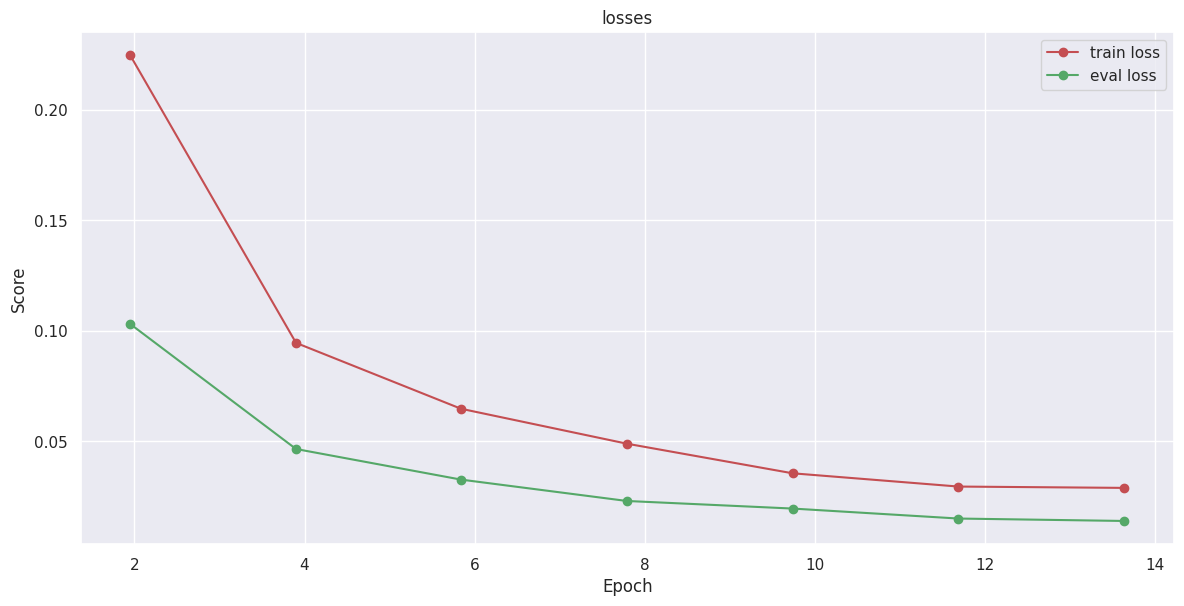

In [37]:
fig_name = "losses"
plot_metric_curve(
    values = [train_loss_values, eval_loss_values],
    epochs = [train_epochs, eval_epochs],
    metrics = ["train loss", "eval loss"],
    title = fig_name,
    path = f"{path_tosave}/{fig_name}.png")

Plot metrics

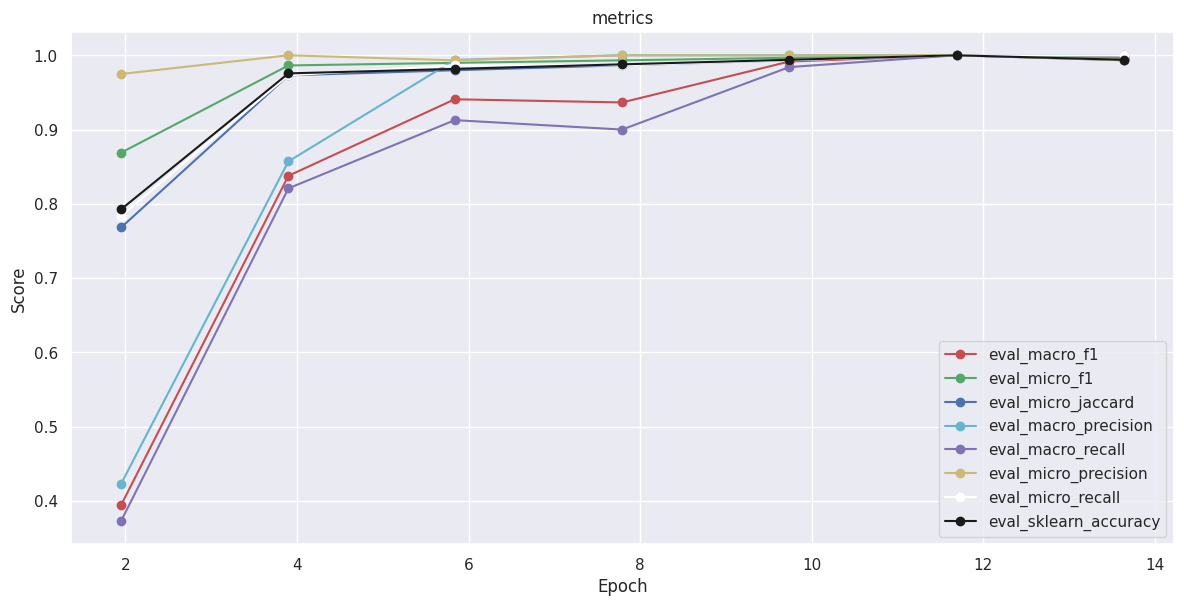

In [38]:
fig_name = "metrics"
plot_metric_curve(
    values = eval_metrics_values[1:],
    epochs = [eval_epochs for _ in eval_metrics_values[1:]],
    metrics = metrics[1:],
    title = fig_name,
    path = f"{path_tosave}/{fig_name}.png")

## Evaluation

In [39]:
def predict_emotions(results, neutral_zero):

  binarized_predictions = np.where(results >= 0.5, 1, 0)

  if not neutral_zero:
    for i, bin_pred in enumerate(binarized_predictions):
      if np.all(bin_pred==0):
        binarized_predictions[i][np.argmax(results[i])] = 1

  predicted_emotions = label_encoder.decode(binarized_predictions)
  return predicted_emotions


In [40]:
print(trainer.state.best_model_checkpoint)

outs = trainer.predict(dev_set)

./SamLowe/roberta-base-go_emotions/checkpoint-1050


Step,Training Loss,Validation Loss,Macro F1,Micro F1,Micro Jaccard,Macro Precision,Macro Recall,Micro Precision,Micro Recall,Sklearn Accuracy,Roc Auc Micro
150,0.224600,0.103045,0.394539,0.868914,0.768212,0.423214,0.373127,0.974790,0.783784,0.792683,0.890392
300,0.094500,0.046489,0.837750,0.986301,0.972973,0.857143,0.820862,1.000000,0.972973,0.975610,0.986486
450,0.064700,0.032649,0.940803,0.989831,0.979866,0.993789,0.912698,0.993197,0.986486,0.981707,0.992743
600,0.048900,0.022980,0.936508,0.993197,0.986486,1.000000,0.900000,1.000000,0.986486,0.987805,0.993243
750,0.035500,0.019547,0.991597,0.996610,0.993243,1.000000,0.984127,1.000000,0.993243,0.993902,0.996622
900,0.029500,0.015030,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1050,0.028900,0.013936,0.996825,0.996633,0.993289,0.993789,1.000000,0.993289,1.000000,0.993902,0.999500


In [41]:
if TASK == "EMO":
  golds = label_encoder.decode(outs.label_ids)
  predictions = predict_emotions(outs.predictions[0], neutral_zero)
if TASK == "EMP":
  golds = outs.label_ids
  predictions = outs.predictions[0]

In [42]:
path_predictions = f"{path_tosave}/dev_predictions_{TASK}.tsv"
path_metrics = f"{path_tosave}/dev_metrics_{TASK}.json"

scores = {
    'train_loss': float(best_train_loss),
    'eval_loss': float(best_eval_loss)
}

write_predictions(predictions, path_predictions)
challenge_metrics = compute_metrics(golds=golds, predictions=predictions, task=TASK)
scores.update(challenge_metrics)
scores['best_metric'] = float(best_metric)
scores['best_epoch_metric'] = float(best_epoch_metric)
scores['best_epoch_eval_loss'] =  float(best_epoch_eval_loss)

write_dict_to_json(scores, path_metrics)

scores

{'train_loss': 0.0289,
 'eval_loss': 0.013935728929936886,
 'macro_f1': 0.9704,
 'micro_f1': 0.9937,
 'micro_jaccard': 0.9875,
 'macro_precision': 0.9988,
 'macro_recall': 0.9505,
 'micro_precision': 0.9958,
 'micro_recall': 0.9916,
 'best_metric': 1.0,
 'best_epoch_metric': 11.69,
 'best_epoch_eval_loss': 13.64}

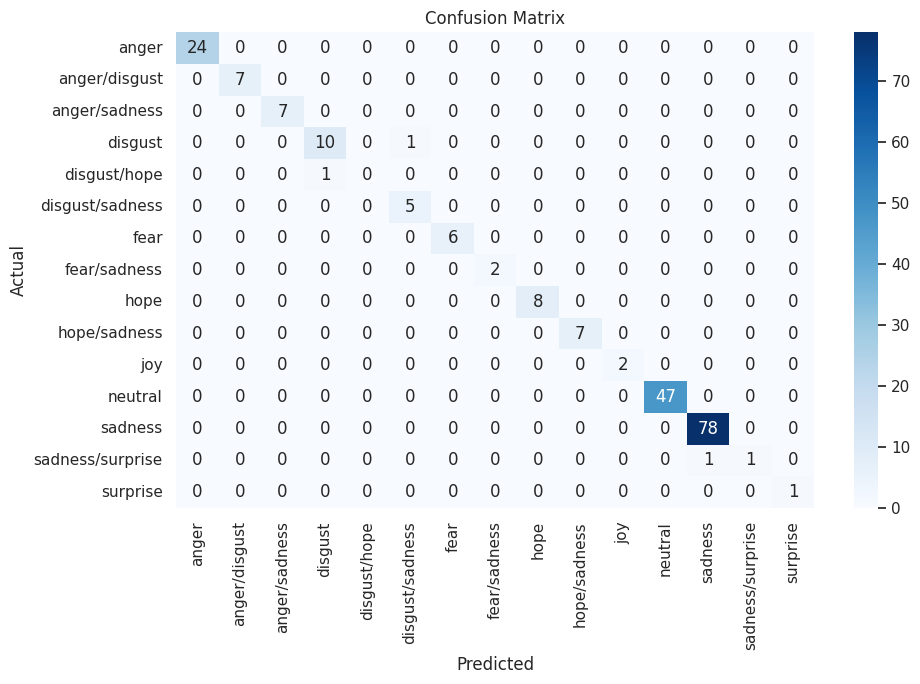

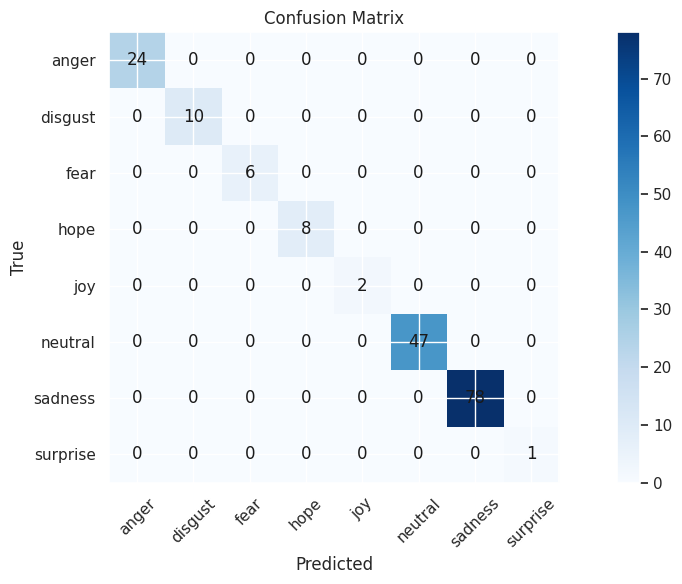

In [43]:
if TASK == "EMO":
  fig_name = "confusion_matrix"
  plot_confusion_matrix(golds=golds,
                        predictions=predictions,
                        path= f"{path_tosave}/{fig_name}.png"
                        )
  print("\n")
  fig_name = "confusion_matrix_per_emotions"
  plot_confusion_matrix_per_emotions(gold_emotions = golds,
                                     predicted_emotions = predictions,
                                     path= f"{path_tosave}/{fig_name}.png"
                                     )

if TASK == "EMP":
  fig_name = f"empathy_true_vs_predicted"
  plot_true_vs_predicted(golds = golds[:,0],
                        predictions = predictions[:,0],
                        path= f"{path_tosave}/{fig_name}.png"
                        )
  print("\n")
  fig_name = f"distress_true_vs_predicted"
  plot_true_vs_predicted(golds = golds[:,1],
                        predictions = predictions[:,1],
                        path= f"{path_tosave}/{fig_name}.png"
                        )
  print("\n")
  fig_name = f"abs_diff_true_vs_predicted"
  plot_abs_diff_emp(golds = golds,
                        predictions = predictions,
                        path= f"{path_tosave}/{fig_name}.png"
                        )

In [46]:
dev_df

,conversation_id,article_id,essay,speaker_id,gender,education,race,age,income,speaker_number,...,disgust_count,joy_count,hope_count,empathy_count,distress_count,empathy_level,distress_level,prompt_bio,prompt_emp,prompt_emo
0,1,35,How sad is it that this kind of pain and suffe...,68,2,2,1,21,20000,1,...,0.038462,0.115385,0.000000,2.956919,2.770749,medium,low,An essay written by a 21 years old white femal...,The essay expresses medium empathy and low dis...,This essays exprsses sadness
1,4,35,The article is kind of tragic and hits close t...,79,1,6,3,33,64000,1,...,0.000000,0.125000,0.000000,2.953607,2.650017,medium,low,An essay written by a 33 years old black or af...,The essay expresses medium empathy and low dis...,This essays exprsses sadness
2,7,213,"I think that these kinds of stories, are sad, ...",68,2,2,1,21,20000,1,...,0.045455,0.136364,0.142857,2.878654,2.688606,medium,medium,An essay written by a 21 years old white femal...,The essay expresses medium empathy and medium ...,This essays exprsses sadness
3,9,213,It's crazy that random accidents like this hap...,84,2,4,1,25,55000,1,...,0.034483,0.103448,0.066667,2.492910,2.438538,low,low,An essay written by a 25 years old white femal...,The essay expresses low empathy and low distre...,This essays exprsses neutral
4,12,78,This story makes me so so sad.... As someone w...,68,2,2,1,21,20000,1,...,0.000000,0.133333,0.090909,2.664856,2.596052,low,low,An essay written by a 21 years old white femal...,The essay expresses low empathy and low distre...,This essays exprsses sadness
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,471,297,"After reading the article, you can't help but ...",70,1,6,1,29,85000,2,...,0.047619,0.000000,0.000000,2.755667,2.571455,low,low,"An essay written by a 29 years old white male,...",The essay expresses low empathy and low distre...,"This essays exprsses fear, sadness"
204,478,53,I am definiltly guilty of wasting food. I buy ...,68,2,2,1,21,20000,2,...,0.074074,0.148148,0.000000,2.548363,2.530183,low,low,An essay written by a 21 years old white femal...,The essay expresses low empathy and low distre...,This essays exprsses sadness
205,484,292,I wish this article had given us more info. We...,68,2,2,1,21,20000,2,...,0.000000,0.071429,0.166667,2.593393,2.603192,low,low,An essay written by a 21 years old white femal...,The essay expresses low empathy and low distre...,This essays exprsses neutral
206,494,218,This story is really horrifying to me. Knowing...,96,2,3,1,27,25000,2,...,0.142857,0.047619,0.062500,2.892870,2.783871,medium,medium,An essay written by a 27 years old white femal...,The essay expresses medium empathy and medium ...,This essays exprsses fear


## Inference on test set

In [44]:
TEST_DATA = f"{repo_path}{branch}/datasets/WASSA23_essay_level_test_preproc.tsv"
test_df = pd.read_csv(TEST_DATA, sep='\t')

num_missing_features = 0
if config['gold_emotions']:
    num_missing_features += 8
if config['gold_empathy']:
    num_missing_features += 1
if config['gold_distress']:
    num_missing_features += 1

global_features = standard_scalar_features(np.array(test_df[config.get('global_features_names')]))
if num_missing_features > 0:
    global_features = np.concatenate((global_features, np.zeros((100, num_missing_features), int)), axis=1)

test_set = WASSADataset(tokenizer=tokenizer,
                    essay=test_df.essay,
                    essay_id = test_df.essay_id,
                    targets=None,
                    prompt_after_SEP=np.array(test_df['prompt_bio']),
                    global_features = global_features,
                    prompt_inlcusion_prob=0
                )

outs = trainer.predict(test_set)
predictions = outs.predictions[0]

path_predictions = f"{path_tosave}/predictions_{TASK}.tsv"
write_predictions(predictions, path_predictions)

write_predictions(predict_emotions(predictions, neutral_zero),'./EMO_preds.tsv')

Step,Training Loss,Validation Loss,Macro F1,Micro F1,Micro Jaccard,Macro Precision,Macro Recall,Micro Precision,Micro Recall,Sklearn Accuracy,Roc Auc Micro
150,0.224600,0.103045,0.394539,0.868914,0.768212,0.423214,0.373127,0.974790,0.783784,0.792683,0.890392
300,0.094500,0.046489,0.837750,0.986301,0.972973,0.857143,0.820862,1.000000,0.972973,0.975610,0.986486
450,0.064700,0.032649,0.940803,0.989831,0.979866,0.993789,0.912698,0.993197,0.986486,0.981707,0.992743
600,0.048900,0.022980,0.936508,0.993197,0.986486,1.000000,0.900000,1.000000,0.986486,0.987805,0.993243
750,0.035500,0.019547,0.991597,0.996610,0.993243,1.000000,0.984127,1.000000,0.993243,0.993902,0.996622
900,0.029500,0.015030,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1050,0.028900,0.013936,0.996825,0.996633,0.993289,0.993789,1.000000,0.993289,1.000000,0.993902,0.999500


In [ ]:
# TODO:

if TASK=="EMP" and include_predicted_prompt:
    test_df = get_emp_levels(test_df, predictions[:,0], predictions[:,1])

    for idx, row in test_df.iterrows():
        _, text_prompt_emp, _ = generate_prompt(
                                    row['essay'],
                                    row['article_id'],
                                    row['gender'],
                                    row['education'],
                                    row['race'],
                                    row['age'],
                                    row['income'],
                                    row['empathy_level'],
                                    row['distress_level']
                                    )
        essay = row['essay']
        test_df.at[idx, "essay"] = essay + " " + text_prompt_emp


    test_set = WASSADataset(tokenizer=tokenizer,
                        essay=test_df.essay,
                        essay_id = test_df.essay_id,
                        targets=None,
                        prompt_after_SEP=np.array(test_df['prompt_bio']),
                        global_features = global_features,
                        prompt_inlcusion_prob=0
                    )


    outs = trainer.predict(test_set)
    predictions = outs.predictions[0]

    path_predictions = f"{path_tosave}/predictions_{TASK}_pred_prompt.tsv"
    write_predictions(predictions, path_predictions)

In [ ]:
path_predictions = "./preds"
write_predictions(predict_emotions(predictions, neutral_zero), path_predictions)

## Inference

In [ ]:
# TODO:

def load_checkpoint_and_compute_metrics(checkpoint_path, test_set, neutral_zero):

  model = CustomSequenceClassification.from_pretrained(checkpoint_path,
                                                     problem_type = problem_type,
                                                     classifier_dropout = config.get('dropout'),
                                                     model_class = config.get('model_class_string'),
                                                     num_labels=config.get('num_labels'),
                                                     dim_extra_features = config.get('dim_extra_features'),
                                                     local_features_names = config.get('local_features_names'),
                                                     n_last_cls = config.get('n_last_cls'),
                                                     mean_last_cls = config.get('mean_last_cls'),
                                                     concat_local_features = config.get('concat_local_features'),
                                                     loss_weights = loss_weights_train,
                                                     ignore_mismatched_sizes=True
                                                    )
  trainer = Trainer(model=model)
  # Perform prediction using the loaded checkpoint
  outs = trainer.predict(test_set)

  if TASK == "EMO":
    golds = label_encoder.decode(outs.label_ids)
    predictions = predict_emotions(outs.predictions[0], neutral_zero)
  if TASK == "EMP":
    golds = outs.label_ids
    predictions = outs.predictions[0]

  path_predictions = f"{path_tosave}/predictions_{TASK}_best_metric.tsv"
  path_metrics = f"{path_tosave}/dev_metrics_{TASK}_best_metric.json"

  write_predictions(predictions, path_predictions)
  challenge_metrics = compute_metrics(golds=golds, predictions=predictions, task=TASK)

  write_dict_to_json(challenge_metrics, path_metrics)

  print(challenge_metrics)


In [ ]:
best_metric_path = f"/content/{config.get('model_name')}/checkpoint-{best_steps}"
load_checkpoint_and_compute_metrics(best_metric_path, dev_set, neutral_zero)

## Save on Google Drive

In [ ]:
# move the best checkpoint in the folder with model id
best_model_path = trainer.state.best_model_checkpoint

!mv $best_model_path /content/$path_tosave

In [ ]:
# move the checkpoint with best metric in the folder with model id
!mv $best_metric_path /content/$path_tosave

In [ ]:
# move the results to personal drive
!mv /content/$path_tosave /content/drive/MyDrive/hlt